# A. Packages

In [2]:
import math
import random
import fiona
import shapely
import os
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fiona
import geopandas as gpd
from shapely.geometry import shape
from shapely.ops import nearest_points
import numpy as np
import rasterio
from rasterstats import zonal_stats
from rasterio.features import shapes
from shapely.geometry import shape

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# B. Simulations

In [15]:
q = 0.3
p = 0.17
actual_props = [random.random() for i in range(100)]
target_props = [0.3 for i in range(100)]
# 1 - abs(p-q)/0.3


In [10]:
1 - abs(p-q)/sum(target_props)

0.9956666666666667

In [7]:
target_props

[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

## B.2 Gini sim

In [25]:
import numpy as np

def gini_index(p):
    """
    Calculate the Gini index for a given distribution.
    
    Parameters:
    p (array): Array representing the distribution proportions.
    
    Returns:
    float: Gini index.
    """
    n = len(p)  # Number of elements in the array p
    
    sorted_p = np.sort(p)  # Sort the array p in ascending order
    
    # Calculate the Gini index using the correct formula
    sum_i_p = np.sum((np.arange(1, n + 1) * sorted_p))  # Weighted sum of sorted proportions
    gini = (2 * sum_i_p) / (n * np.sum(sorted_p)) - (n + 1) / n
    
    return gini

def calculate_gini_indicator(A, P):
    """
    Calculate the biodiversity 30x30 target 3 indicator using the Gini index.
    
    Parameters:
    A (array): Total area of each ecoregion.
    P (array): Protected area within each ecoregion.
    
    Returns:
    float: Indicator value bounded between 0 and 1.
    """
    # Calculate the proportion of protected area relative to total area for each ecoregion
    p_per_area = P / A
    
    # Calculate the Gini index for the protected area proportions
    gini_protected = gini_index(p_per_area)
    
    # Normalize the Gini index to get the indicator (1 - Gini index)
    indicator = 1 - gini_protected
    
    return indicator  # Return the indicator value

# Simulate data for testing
np.random.seed(42)  # For reproducibility
num_ecoregions = 4
total_areas = np.random.uniform(100, 1000, num_ecoregions)  # Total area of each ecoregion
# protected_areas = np.random.uniform(0, total_areas)  # Protected area within each ecoregion
protected_areas = [0.25*area for area in total_areas]
?np.random.uniform
# Calculate the indicator
indicator_value = calculate_gini_indicator(total_areas, protected_areas)

# Print the results
print("Total Areas of Ecoregions:", total_areas)
print("Protected Areas within Ecoregions:", protected_areas)
print("Biodiversity 30x30 Target 3 Indicator:", indicator_value)


Total Areas of Ecoregions: [437.08610696 955.64287577 758.79454763 638.79263578]
Protected Areas within Ecoregions: [109.27152674065655, 238.91071894223114, 189.69863690756614, 159.69815894433324]
Biodiversity 30x30 Target 3 Indicator: 1.0


Docstring:
uniform(low=0.0, high=1.0, size=None)

Draw samples from a uniform distribution.

Samples are uniformly distributed over the half-open interval
``[low, high)`` (includes low, but excludes high).  In other words,
any value within the given interval is equally likely to be drawn
by `uniform`.

.. note::
    New code should use the `~numpy.random.Generator.uniform`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
low : float or array_like of floats, optional
    Lower boundary of the output interval.  All values generated will be
    greater than or equal to low.  The default value is 0.
high : float or array_like of floats
    Upper boundary of the output interval.  All values generated will be
    less than or equal to high.  The high limit may be included in the 
    returned array of floats due to floating-point rounding in the 
    equation ``low + (high-low) * random_sample()``.  The default v

### Gini Index Formula

The Gini index is calculated using the following formula:

$$
G = \frac{2 \sum_{i=1}^{n} i \cdot p_i}{n \sum_{i=1}^{n} p_i} - \frac{n + 1}{n}
$$

Where:
- *n* is the number of observations.
- $p_{i}$ is the value at position *i* in the sorted array.


# C. Geospatial

In [3]:
ecozone_path = r"C:\Users\ilebe\Documents\!Masters!\BIOS2\Biodiversity indicators\Target 3 indicator\Ecoregion shapefile"
protected_areas_path = r"C:\Users\ilebe\Documents\!Masters!\BIOS2\Biodiversity indicators\Target 3 indicator\ProtectedConservedArea_2023\ProtectedConservedArea_2023.gdb"

In [4]:
ecozones = gpd.read_file(os.path.join(ecozone_path, "ecoregions.shp"))

In [23]:
ecozone_area = ecozones.groupby(by = "ECOZONE").agg({'AREA': "sum"}, index = False)

In [24]:
ecozone_area

,AREA
ECOZONE,
1,104.14075
2,756.53902
3,300.76924
4,118.55645
5,222.27207
6,267.96489
7,33.11873
8,19.13901
9,104.42423


In [7]:
ecozones.head(3)

,AREA,PERIMETER,REGION_,REGION_ID,ECOREGION,REGION_NAM,REGION_NOM,ECOZONE,geometry
0,49.25608,164.46251,2,1,8,Ellesmere Mountains,Chaîne Ellesmere,2,"POLYGON ((-68.20408 82.46110, -68.21848 82.450..."
1,49.63573,146.56887,3,2,9,Eureka Hills,Collines Eureka,2,"POLYGON ((-68.20408 82.46110, -68.22731 82.469..."
2,18.74491,99.14604,4,3,1,Ellesmere and Devon Island IceCaps,Calottes glacières Ellesmere et Devon,1,"POLYGON ((-70.95227 82.90569, -70.91701 82.902..."


In [5]:
ecozones.ECOZONE.unique()

array([ 2,  1,  3, 11,  4,  5, 12,  9, 13,  6, 15, 14, 10,  7,  8],
      dtype=int64)

In [9]:
protected_areas_gdb = gpd.read_file(protected_areas_path)

In [10]:
protected_areas_gdb.head()

,PARENT_ID,NAME_E,NAME_F,NAME_IND,ZONE_ID,ZONEDESC_E,BIOME,JUR_ID,PA_OECM_DF,IUCN_CAT,...,NO_TAKE_HA,MPLAN,MPLAN_REF,M_EFF,AUDITYEAR,AUDITRES,PROVIDER,Shape_Length,Shape_Area,geometry
0,610000101,Thelon Wildlife Sanctuary,Refuge faunique de Thelon,None,610000101,Terrestrial Zone,T,Thelon Wildlife Sanctuary - NWT portion,1,2,...,0.0,1.0,None,0.0,NaN,None,61,830171.275201,2.127009e+10,"MULTIPOLYGON (((-287166.514 2705871.281, -2871..."
1,610000201,Ts’udé Nilįné Tuyeta Territorial Protected Area,Zone terrestre protégée Ts’udé Nilįné Tuyeta,Ts’udé Nilįné Tuyeta,610000201,Terrestrial Zone,T,None,1,2,...,0.0,NaN,None,NaN,NaN,None,61,505364.180100,1.010895e+10,"MULTIPOLYGON (((-1408773.044 3273626.745, -140..."
2,610000202,Thaidene Nëné Territorial Protected Area,Zone terrestre protégée Thaidene Nëné,Thaidene Nëné,610000202,Terrestrial Zone,T,None,1,2,...,0.0,NaN,None,NaN,NaN,None,61,958018.746367,9.106363e+09,"MULTIPOLYGON (((-713146.239 2569701.709, -7121..."
3,610000203,Thaidene Nëné Wildlife Conservation Area,Zone de conservation de la faune Thaidene Nëné,Thaidene Nëné,610000203,Terrestrial Zone,T,None,2,9,...,0.0,NaN,None,NaN,NaN,None,61,221170.089268,3.120447e+09,"MULTIPOLYGON (((-490397.641 2645504.245, -5158..."
4,610000301,Ezǫdzìtì,Ezǫdzìtì,Ezǫdzìtì,610000301,Terrestrial Zone,T,None,1,2,...,0.0,NaN,None,NaN,NaN,None,61,164975.599229,1.375098e+09,"MULTIPOLYGON (((-1063986.349 2881501.817, -109..."


In [11]:
protected_areas_gdb.columns

Index(['PARENT_ID', 'NAME_E', 'NAME_F', 'NAME_IND', 'ZONE_ID', 'ZONEDESC_E',
       'BIOME', 'JUR_ID', 'PA_OECM_DF', 'IUCN_CAT', 'IPCA', 'IND_TERM',
       'O_AREA_HA', 'LOC', 'MECH_E', 'TYPE_E', 'OWNER_TYPE', 'OWNER_E',
       'GOV_TYPE', 'MGMT_E', 'STATUS', 'ESTYEAR', 'QUALYEAR', 'DELISTYEAR',
       'SUBSRIGHT', 'CONS_OBJ', 'NO_TAKE', 'NO_TAKE_HA', 'MPLAN', 'MPLAN_REF',
       'M_EFF', 'AUDITYEAR', 'AUDITRES', 'PROVIDER', 'Shape_Length',
       'Shape_Area', 'geometry'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

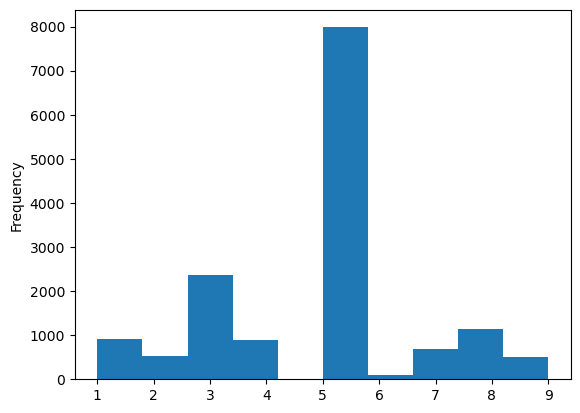

In [26]:
protected_areas_gdb.IUCN_CAT.plot(kind = 'hist')

In [ ]:
protected_areas_gdb

<AxesSubplot:ylabel='Frequency'>

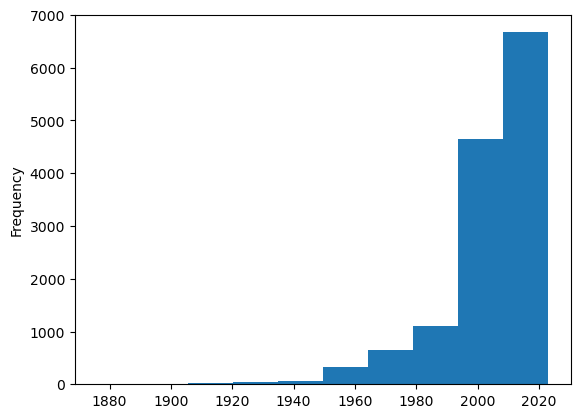

In [20]:
protected_areas_gdb.ESTYEAR.plot(kind = 'hist')